In [81]:
#importing the necessary libraries for the model
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
PATH = "data/"
sz=128

#file operators for splitting datasets
import os
import shutil

#csv operators for creating test csv
import csv

The data has been received as testing and training data, so the training data must be split by 80/20 for the training and validation datasets:

In [ ]:
labels = os.listdir(f'{PATH}/train')

for label in labels:
    os.makedirs(f'{PATH}/valid/{label}')

In [ ]:
'''for label in labels:
    total_samples = os.listdir(f'{PATH}/train/{label}')

    validation_samples = random.sample(total_samples, math.floor((len(total_samples)/5)))

    for picture_name in validation_samples:
        shutil.move(f'{PATH}/train/{label}/{picture_name}', f'{PATH}/valid/{label}/{picture_name}' )'''

The data has been successfully separated, so following code generates a preliminary model for the data with an accuracy of 76%.

In [14]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz), test_name='test')
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)

epoch      trn_loss   val_loss   accuracy                                      
    0      1.861506   1.283591   0.592116  
    1      1.416852   1.07147    0.624408                                      



[1.0714697996775309, 0.624407680829366]

Choosing a learning rate is the next step in fine tuning the model, using the learning rate finder functionality in fastai.

 93%|████████████████████████████▉  | 56/60 [00:01<00:00, 42.59it/s, loss=20.3]


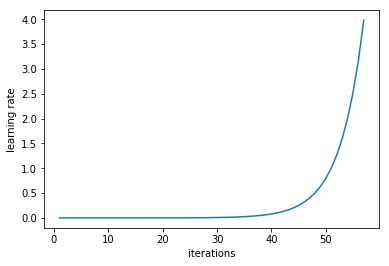

In [15]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
lrf=learn.lr_find()
learn.sched.plot_lr()


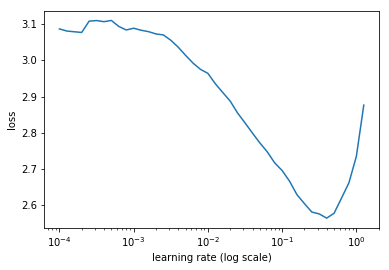

In [16]:
learn.sched.plot()

A learning rate of 0.1 has been chosen, as this is the largest learning rate with the loss still clearly decreasing.

In [17]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_top_down, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [18]:
learn.fit(0.1, 1)

epoch      trn_loss   val_loss   accuracy                                      
    0      1.991104   1.300534   0.605678  



[1.3005343854427338, 0.6056781053543091]

In [19]:
learn.precompute=False

In [20]:
learn.fit(0.1, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                                      
    0      1.453832   0.939696   0.680658  
    1      1.267212   0.913919   0.67835                                       
    2      1.155745   0.867626   0.70049                                       



[0.8676261444886525, 0.7004901965459188]

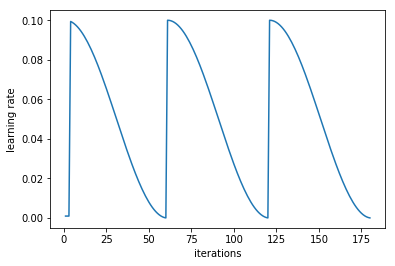

In [21]:
learn.sched.plot_lr()

In [22]:
learn.unfreeze()

In [23]:
lr=np.array([0.025,0.05,0.1])

In [24]:
learn.fit(lr, 4, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                                      
    0      0.986406   0.571687   0.802553  
    1      0.738794   0.525322   0.819506                                      
    2      0.51073    0.304513   0.8846                                        
    3      0.514022   0.641685   0.770016                                      
    4      0.441434   0.429393   0.85335                                       
    5      0.324389   0.240965   0.918219                                      
    6      0.257701   0.212148   0.92498                                       
    7      0.369169   0.573597   0.806209                                      
    8      0.345845   0.669991   0.763746                                      
    9      0.306545   0.263683   0.895302                                      
    10     0.267904   0.233957   0.903636                                      
    11     0.243875   0.200613   0.928901                                   

[0.13550745124618213, 0.9507761438687642]

Having trained the model successfully to 94% accuracy, the confusion matrix can be shown to obtain an overall analysis of the results.

[[0.7992  0.00003 0.0001  ... 0.00004 0.00012 0.00027]                         
 [0.92607 0.00001 0.00005 ... 0.      0.00001 0.00009]
 [0.91618 0.      0.00002 ... 0.      0.00001 0.00004]
 ...
 [0.00011 0.00001 0.      ... 0.      0.      0.99966]
 [0.      0.      0.      ... 0.      0.      0.99994]
 [0.      0.00001 0.      ... 0.      0.      0.99984]]
[[ 34   0   0   0   1   0  17   0   0   0   0   0]
 [  0  76   1   0   0   1   0   0   0   0   0   0]
 [  0   0  55   1   0   0   0   0   1   0   0   0]
 [  0   0   0 121   0   0   1   0   0   0   0   0]
 [  1   0   0   0  43   0   0   0   0   0   0   0]
 [  1   0   0   1   1  92   0   0   0   0   0   0]
 [ 15   0   0   0   0   0 115   0   0   0   0   0]
 [  0   0   0   0   1   0   0  43   0   0   0   0]
 [  0   0   0   0   0   0   0   0 102   1   0   0]
 [  0   0   0   1   0   0   0   0   2  43   0   0]
 [  0   0   0   0   0   0   0   0   0   0  99   0]
 [  0   0   0   0   0   0   0   1   0   0   0  76]]


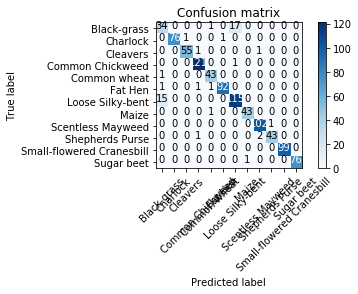

In [25]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

print(probs)

preds = np.argmax(probs, axis=1)
probs = probs[:,1]

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

plot_confusion_matrix(cm, data.classes)

Now that the model has been successfully trained, it will be used to predict the relevant species for the test dataset in the following code. 

In [84]:
trn_tfms, val_tfms = tfms_from_model(arch, sz)
learn.precompute=False

with open("test_results.csv", "w") as csvfile:
    #sets up csv file
    fieldnames = ['file', 'species']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    
    for fn in os.listdir(f'{PATH}/test'):
        im = val_tfms(np.array(open_image(f'{PATH}/test/{fn}')))
        preds = learn.predict_array(im[None])
        
        prediction = data.classes[np.argmax(preds)]
        
        writer.writerow({'file': fn, 'species': prediction})